## Predict Talent Migration with Machine Learning - 02 Modelling

---

<p style="text-align: center;">
Project split into 5 Notebooks:</br>
</br>
Predict Talent Migration with Machine Learning - 01 Exploratory Analysis</br>
*</br>
Predict Talent Migration with Machine Learning - 02 Modeling</br>
*</br>
Predict Talent Migration with Machine Learning - 03 Grid Build</br>
*</br>
Predict Talent Migration with Machine Learning - 04 Final Take Model A</br>
*</br>
Predict Talent Migration with Machine Learning - 05 Final Take Model B</br> </p> 
         
---

This project aims to create a machine learning model that allows the prediction of employees departure from an Organization. </br>
We will focus our forecast on the Organization's best employees (Top Performers), although a comparison between employees in general will be made. Top Performers will be identified through the creation of a condition, which will be based on the classification of employees evaluation cycles. An analysis on model performance will also be presented, concerning the model's ability to predict the employees departure by **Generation** and **Gender.**

Employees are evaluated on a semiannual basis and our data concerns the last 3 evaluation cycles, between January 1st 2018 to September 31st 2019.

Ratings per evaluation are: </br>

  - Mid Year 2018 (MY2018): **0,1,2,3,4,5** </br>
  - Year End 2018 (YE2018): **0,1,2,3,4,5** </br>
  - Mid Year 2019: **0,1,2,3***.</br>
             
**Data from the Organization shows a change of ratings scale was purpousely made to decrease results granularity.*

In [144]:
import random
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import KBinsDiscretizer, PowerTransformer, OneHotEncoder

from sklearn.model_selection import KFold
from sklearn.inspection import permutation_importance

from category_encoders.ordinal import OrdinalEncoder

from sklearn.metrics import roc_auc_score

## Data:

**From the previous notebook "Predict Talent Migration with Machine Learning - 01 Exploratory Analysis ", a modified dataset was saved and will now be our starting point for the modeling phase.**

In [145]:
df = pd.read_csv('projeto_final.csv', index_col = False)

In [146]:
df.head()

,Id,Rehire,Age,Generation,CostCenterH,Gender,Dependents,ManagementLevel,EmployeeCount,HireCount,...,OfficeLocation,Country,ModNationality,2ndNationality,MOfficeLocation,MCountry,Out,MTimeJobProfile,MTimeinPosition,TopPerformer
0,0,No,37.0,Generation Y / Millennials (1981 -1996),Technology,Male,1,Lead,7,7,...,Porto - Lionesa,Portugal,Portugal,0,Porto - Lionesa,Portugal,0,18.215000,19.611000,0
1,1,No,43.0,Generation X (1965 -1980),Technology,Male,1,Head,6,8,...,Porto - Lionesa,Portugal,Portugal,0,Porto - Lionesa,Portugal,0,35.496667,36.891667,0
2,2,No,40.0,Generation X (1965 -1980),Operations,Male,0,Manager,6,1,...,Porto - Boavista,Portugal,Portugal,0,London,UK,0,15.852333,17.248333,0
3,3,No,38.0,Generation Y / Millennials (1981 -1996),Content,Male,1,Individual Contributor,8,1,...,Guimarães,Portugal,Portugal,0,Guimarães,Portugal,0,15.204333,16.600333,0
4,4,No,37.0,Generation Y / Millennials (1981 -1996),Operations,Female,2,Individual Contributor,11,3,...,Porto - Boavista,Portugal,Portugal,0,Porto - Lionesa,Portugal,0,7.836000,9.232000,0


In [147]:
df[df['Out'] == 1]

,Id,Rehire,Age,Generation,CostCenterH,Gender,Dependents,ManagementLevel,EmployeeCount,HireCount,...,OfficeLocation,Country,ModNationality,2ndNationality,MOfficeLocation,MCountry,Out,MTimeJobProfile,MTimeinPosition,TopPerformer
23,23,No,36.0,Generation Y / Millennials (1981 -1996),Finance,Female,1,Lead,2,1,...,Porto - Lionesa,Portugal,Portugal,0,Porto - Lionesa,Portugal,1,5.740000,36.891667,0
32,32,No,40.0,Generation X (1965 -1980),Digital Production,Male,0,Individual Contributor,9,9,...,Guimarães,Portugal,NaN,0,Los Angeles - Arts,USA,1,24.336333,45.009000,0
42,42,No,36.0,Generation Y / Millennials (1981 -1996),Technology,Female,1,Head,5,12,...,Porto - Lionesa,Portugal,Portugal,0,Porto - Lionesa,Portugal,1,7.702667,36.891667,0
46,46,No,37.0,Generation Y / Millennials (1981 -1996),Finance,Male,0,Individual Contributor,5,4,...,Porto - Boavista,Portugal,Portugal,0,Porto - Boavista,Portugal,1,0.966667,36.891667,0
52,52,No,35.0,Generation Y / Millennials (1981 -1996),Digital Production,Female,0,Individual Contributor,24,11,...,Guimarães,Portugal,NaN,0,Guimarães,Portugal,1,24.750000,49.066667,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5547,5547,No,27.0,Generation Y / Millennials (1981 -1996),Operations,Female,0,Individual Contributor,10,8,...,Shanghai - One Museum,China,China,0,Shanghai - One Museum,China,1,1.881333,19.163000,0
5596,5596,No,27.0,Generation Y / Millennials (1981 -1996),Digital Production,Female,0,Individual Contributor,7,11,...,Guimarães,Portugal,Portugal,0,Guimarães,Portugal,1,0.900000,23.703000,0
5606,5606,No,25.0,Generation Y / Millennials (1981 -1996),Digital Production,Female,0,Individual Contributor,3,10,...,Beijing - TechTemple,China,China,0,Beijing - TechTemple,China,1,25.964667,28.508667,0
5611,5611,No,23.0,Generation Y / Millennials (1981 -1996),Private Client,Male,0,Individual Contributor,10,4,...,São Paulo - Santos Augusta,Brazil,Brazil,0,São Paulo - Santos Augusta,Brazil,1,0.566667,6.454667,0


In [148]:
df.isnull().sum()

Id                     0
Rehire                 0
Age                   14
Generation             0
CostCenterH            0
Gender                 0
Dependents             0
ManagementLevel        0
EmployeeCount          0
HireCount              0
TerminationCount       0
Tenure                 0
PayIncrease            0
PeopleManager          0
BLeave                 0
BTimeOut               0
ParentLeave            0
HomeOffice             0
Contract Type          0
MProximity             0
MTenure                0
MManagementLevel       0
MBoomerang             0
MParentLeave           0
MHomeoffice            0
MY2018              4090
YE2018              3541
MY2019              3428
ARHappiness         5120
ARStay              5120
ARResponses         5120
DRHappiness         5504
DRStay              5504
DRResponses         5504
TimeJobProfile         0
TimeinPosition         0
OfficeLocation         1
Country                1
ModNationality       392
2ndNationality         0


In [149]:
X = df.copy()

In [150]:
y = df.pop('Out')

In [151]:
X.shape

(5684, 46)

In [152]:
y.shape

(5684,)

## Train - Test Split

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [154]:
X_train.shape

(4547, 46)

In [155]:
X_test.shape

(1137, 46)

---

**From the previous notebook, we closed by analyzing individual graphics of the most impactful variables on the prediction of an employee exit from the Organization, and from that analysis, variables Tenure, PayIncrease and Generation were chosen to kickstart our Baseline.**

**Considering our end goal being the prediction of an event taking place or not, represented by 0 - not happening and 1 - happening, it is identied as a classification problem. A comparision between Logistic Regression, Random Forest and Gradient Boosting models will take place, by progressively adding complexity to the models in the form of variables.**

**Models performance will be evaluated through Cross Validation Scores.**

---

## Take 1 - Baseline:

**Data transformation + Pipeline (Logistic Regression, Random Forest, Gradient Boosting) + Results**

**Features: Tenure, PayIncrease, Generation**

In [156]:
transf_v1 = ColumnTransformer(
    [('cat', OneHotEncoder(drop = 'first'), ['Generation']),
     ('null', SimpleImputer (missing_values= np.nan, strategy = 'median'), ['PayIncrease']), 
     ('other', "passthrough", ['Tenure'])
    ])

### Pipeline: 

**Logistic Regression:**

In [157]:
model_log = Pipeline([
    ('Feature Eng', transf_v1),
    ('Regressão', LogisticRegression())
])

model_log.steps

[('Feature Eng',
  ColumnTransformer(transformers=[('cat', OneHotEncoder(drop='first'),
                                   ['Generation']),
                                  ('null', SimpleImputer(strategy='median'),
                                   ['PayIncrease']),
                                  ('other', 'passthrough', ['Tenure'])])),
 ('Regressão', LogisticRegression())]

## Results - Cross Validation: 

In [158]:
results_log = cross_val_score(model_log, X_train, y_train, cv = KFold(n_splits = 5, shuffle = True), scoring = "roc_auc")

In [159]:
results_log_mean = results_log.mean()
results_log_std = results_log.std()

In [160]:
results_log_mean

0.6370347112999883

In [161]:
results_log_std

0.02244223630569095

**Random Forest:**

In [162]:
model_for = Pipeline([
    ('Feature Eng', transf_v1),
    ('Random Forest', RandomForestRegressor())
])

In [163]:
results_for = cross_val_score(model_for, X_train, y_train, cv = KFold(n_splits = 5, shuffle = True), scoring = "roc_auc")

In [164]:
results_for_mean = results_for.mean()
results_for_std = results_for.std()

In [165]:
results_for_mean

0.6807048150418487

In [166]:
results_for_std

0.029880307767149783

**Gradient Boosting:**

In [167]:
model_boost = Pipeline([
    ('Feature Eng', transf_v1),
    ('Gradient Boosting', GradientBoostingClassifier())
])

In [168]:
results_boost = cross_val_score(model_boost, X_train, y_train, cv = KFold(n_splits = 5, shuffle = True), scoring = "roc_auc")

In [169]:
results_boost_mean = results_boost.mean()
results_boost_std = results_boost.std()

In [170]:
results_boost_mean

0.7156251351799721

In [171]:
results_boost_std

0.018514017626958455

---

## Take 2

**Features: Baseline(Tenure, PayIncrease, Generation) + Gender**

In [172]:
transf_v2 = ColumnTransformer(
    [('cat', OneHotEncoder(drop = 'first'), ['Generation', 'Gender']),
     ('null', SimpleImputer (missing_values= np.nan, strategy = 'median'), ['PayIncrease']), 
     ('other', "passthrough", ['Tenure'])
    ])

**Logistic Regression:**

In [173]:
model_log_2 = Pipeline([
    ('Feature Eng', transf_v2),
    ('Regressão', LogisticRegression())
])

model_log_2.steps

[('Feature Eng',
  ColumnTransformer(transformers=[('cat', OneHotEncoder(drop='first'),
                                   ['Generation', 'Gender']),
                                  ('null', SimpleImputer(strategy='median'),
                                   ['PayIncrease']),
                                  ('other', 'passthrough', ['Tenure'])])),
 ('Regressão', LogisticRegression())]

**Results:**

In [174]:
results_log_2 = cross_val_score(model_log_2, X_train, y_train, cv = KFold(n_splits = 5, shuffle = True), scoring = "roc_auc")
results_log_2_mean = results_log_2.mean()
results_log_2_std = results_log_2.std()

/Users/ElsaSilva/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ElsaSilva/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

In [175]:
results_log_2_mean

0.633003101534066

In [176]:
results_log_2_std

0.024258101767830945

**Random Forest:**

In [177]:
model_for_2 = Pipeline([
    ('Feature Eng', transf_v2),
    ('Random Forest', RandomForestRegressor())
     ])

model_for_2.steps

[('Feature Eng',
  ColumnTransformer(transformers=[('cat', OneHotEncoder(drop='first'),
                                   ['Generation', 'Gender']),
                                  ('null', SimpleImputer(strategy='median'),
                                   ['PayIncrease']),
                                  ('other', 'passthrough', ['Tenure'])])),
 ('Random Forest', RandomForestRegressor())]

In [178]:
results_for_2 = cross_val_score(model_for_2, X_train, y_train, cv = KFold(n_splits = 5, shuffle = True), scoring = "roc_auc")
results_for_2_mean = results_for_2.mean()
results_for_2_std = results_for_2.std()

In [179]:
results_for_2_mean

0.6767915459760753

In [180]:
results_for_2_std

0.006656060569364297

**Gradient Boosting:**

In [181]:
model_boost_2 = Pipeline([
    ('Feature Eng', transf_v2),
    ('Gradient Boosting', GradientBoostingClassifier())
])

model_boost_2.steps

[('Feature Eng',
  ColumnTransformer(transformers=[('cat', OneHotEncoder(drop='first'),
                                   ['Generation', 'Gender']),
                                  ('null', SimpleImputer(strategy='median'),
                                   ['PayIncrease']),
                                  ('other', 'passthrough', ['Tenure'])])),
 ('Gradient Boosting', GradientBoostingClassifier())]

**Results:**

In [182]:
results_boost_2 = cross_val_score(model_boost_2, X_train, y_train, cv = KFold(n_splits = 5, shuffle = True), scoring = "roc_auc")
results_boost_2_mean = results_boost_2.mean()
results_boost_2_std = results_boost_2.std()

In [183]:
results_boost_2_mean

0.7192689180033792

In [184]:
results_boost_2_std

0.0070339652018757285

---

## Take 3 

**Features: Baseline(Tenure, PayIncrease, Generation) + Gender + Dependents**

In [185]:
transf_v3 = ColumnTransformer(
    [('cat', OneHotEncoder(drop = 'first'), ['Generation', 'Gender']),
     ('null', SimpleImputer (missing_values= np.nan, strategy = 'median'), ['PayIncrease']), 
     ('other', "passthrough", ['Tenure', 'Dependents'])
    ])

**Logistic Regression:**

In [186]:
model_log_3 = Pipeline([
    ('Feature Eng', transf_v3),
    ('Regressão', LogisticRegression())
])

model_log_3.steps

[('Feature Eng',
  ColumnTransformer(transformers=[('cat', OneHotEncoder(drop='first'),
                                   ['Generation', 'Gender']),
                                  ('null', SimpleImputer(strategy='median'),
                                   ['PayIncrease']),
                                  ('other', 'passthrough',
                                   ['Tenure', 'Dependents'])])),
 ('Regressão', LogisticRegression())]

**Results:**

In [187]:
results_log_3 = cross_val_score(model_log_3, X_train, y_train, cv = KFold(n_splits = 5, shuffle = True), scoring = "roc_auc")
results_log_3_mean = results_log_3.mean()
results_log_3_std = results_log_3.std()

/Users/ElsaSilva/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ElsaSilva/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

#### Note: Features "Tenure" + "Dependents" - have different scales. It generates problems in the Logistic Regression modeling.

#### Therefore, and given the significant drop in model performance, we decided to abandon the logistic approach and focus exclusively on the Random Forest and Gradient Boosting classification models.

---

**Random Forest:**

In [188]:
model_for_3 = Pipeline([
    ('Feature Eng', transf_v3),
    ('Random Forest', RandomForestRegressor())
     ])

model_for_3.steps

[('Feature Eng',
  ColumnTransformer(transformers=[('cat', OneHotEncoder(drop='first'),
                                   ['Generation', 'Gender']),
                                  ('null', SimpleImputer(strategy='median'),
                                   ['PayIncrease']),
                                  ('other', 'passthrough',
                                   ['Tenure', 'Dependents'])])),
 ('Random Forest', RandomForestRegressor())]

**Results:**

In [189]:
results_for_3 = cross_val_score(model_for_3, X_train, y_train, cv = KFold(n_splits = 5, shuffle = True), scoring = "roc_auc")
results_for_3_mean = results_for_3.mean()
results_for_3_std = results_for_3.std()

In [190]:
results_for_3_mean

0.684531118559078

In [191]:
results_for_3_std

0.016850496027827157

**Gradient Boosting:**

In [192]:
model_boost_3 = Pipeline([
    ('Feature Eng', transf_v3),
    ('Gradient Boosting', GradientBoostingClassifier())
])

model_boost_3.steps

[('Feature Eng',
  ColumnTransformer(transformers=[('cat', OneHotEncoder(drop='first'),
                                   ['Generation', 'Gender']),
                                  ('null', SimpleImputer(strategy='median'),
                                   ['PayIncrease']),
                                  ('other', 'passthrough',
                                   ['Tenure', 'Dependents'])])),
 ('Gradient Boosting', GradientBoostingClassifier())]

**Results:**

In [193]:
results_boost_3 = cross_val_score(model_boost_3, X_train, y_train, cv = KFold(n_splits = 5, shuffle = True), scoring = "roc_auc")
results_boost_3_mean = results_boost_3.mean()
results_boost_3_std = results_boost_3.std()

In [194]:
results_boost_3_mean

0.7225942657851662

In [195]:
results_boost_3_std

0.0083430799227458

---

## Take 4: 

**Features: Baseline(Tenure, PayIncrease, Generation) + Gender + Dependents + TimeJobProfile**

In [196]:
transf_v4 = ColumnTransformer(
    [('cat', OneHotEncoder(drop = 'first'), ['Generation', 'Gender']),
     ('null', SimpleImputer (missing_values= np.nan, strategy = 'median'), ['PayIncrease']), 
     ('other', "passthrough", ['Tenure', 'Dependents', 'TimeJobProfile'])
    ])

**Random Forest:**

In [197]:
model_for_4 = Pipeline([
    ('Feature Eng', transf_v4),
    ('Random Forest', RandomForestRegressor())
     ])

model_for_4.steps

[('Feature Eng',
  ColumnTransformer(transformers=[('cat', OneHotEncoder(drop='first'),
                                   ['Generation', 'Gender']),
                                  ('null', SimpleImputer(strategy='median'),
                                   ['PayIncrease']),
                                  ('other', 'passthrough',
                                   ['Tenure', 'Dependents', 'TimeJobProfile'])])),
 ('Random Forest', RandomForestRegressor())]

**Results:**

In [198]:
results_for_4 = cross_val_score(model_for_4, X_train, y_train, cv = KFold(n_splits = 5, shuffle = True), scoring = "roc_auc")
results_for_4_mean = results_for_4.mean()
results_for_4_std = results_for_4.std()

In [199]:
results_for_4_mean

0.8785698942120606

In [200]:
results_for_4_std

0.0067432171591416444

**Gradient Boosting:**

In [201]:
model_boost_4 = Pipeline([
    ('Feature Eng', transf_v4),
    ('Gradient Boosting', GradientBoostingClassifier())
])

model_boost_4.steps

[('Feature Eng',
  ColumnTransformer(transformers=[('cat', OneHotEncoder(drop='first'),
                                   ['Generation', 'Gender']),
                                  ('null', SimpleImputer(strategy='median'),
                                   ['PayIncrease']),
                                  ('other', 'passthrough',
                                   ['Tenure', 'Dependents', 'TimeJobProfile'])])),
 ('Gradient Boosting', GradientBoostingClassifier())]

**Results:**

In [202]:
results_boost_4 = cross_val_score(model_boost_4, X_train, y_train, cv = KFold(n_splits = 5, shuffle = True), scoring = "roc_auc")
results_boost_4_mean = results_boost_4.mean()
results_boost_4_std = results_boost_4.std()

In [203]:
results_boost_4_mean

0.8624076736289963

In [204]:
results_boost_4_std

0.01356310948737609

---

## Take 5:

**Features: Baseline(Tenure, PayIncrease, Generation) + Gender + Dependents + TimeJobProfile + MProximity**

In [205]:
transf_v5 = ColumnTransformer(
    [('cat', OneHotEncoder(drop = 'first'), ['Generation', 'Gender', 'MProximity']),
     ('null', SimpleImputer (missing_values= np.nan, strategy = 'median'), ['PayIncrease']), 
     ('other', "passthrough", ['Tenure', 'Dependents', 'TimeJobProfile'])
    ])

**Random Forest:**

In [206]:
model_for_5 = Pipeline([
    ('Feature Eng', transf_v5),
    ('Random Forest', RandomForestRegressor())
     ])

model_for_5.steps

[('Feature Eng',
  ColumnTransformer(transformers=[('cat', OneHotEncoder(drop='first'),
                                   ['Generation', 'Gender', 'MProximity']),
                                  ('null', SimpleImputer(strategy='median'),
                                   ['PayIncrease']),
                                  ('other', 'passthrough',
                                   ['Tenure', 'Dependents', 'TimeJobProfile'])])),
 ('Random Forest', RandomForestRegressor())]

**Results:**

In [207]:
results_for_5 = cross_val_score(model_for_5, X_train, y_train, cv = KFold(n_splits = 5, shuffle = True), scoring = "roc_auc")
results_for_5_mean = results_for_5.mean()
results_for_5_std = results_for_5.std()

In [208]:
results_for_5_mean

0.8847964882478001

In [209]:
results_for_5_std

0.008096366158671844

**Gradient Boosting:**

In [210]:
model_boost_5 = Pipeline([
    ('Feature Eng', transf_v5),
    ('Gradient Boosting', GradientBoostingClassifier())
])

model_boost_5.steps

[('Feature Eng',
  ColumnTransformer(transformers=[('cat', OneHotEncoder(drop='first'),
                                   ['Generation', 'Gender', 'MProximity']),
                                  ('null', SimpleImputer(strategy='median'),
                                   ['PayIncrease']),
                                  ('other', 'passthrough',
                                   ['Tenure', 'Dependents', 'TimeJobProfile'])])),
 ('Gradient Boosting', GradientBoostingClassifier())]

**Results:**

In [211]:
results_boost_5 = cross_val_score(model_boost_5, X_train, y_train, cv = KFold(n_splits = 5, shuffle = True), scoring = "roc_auc")
results_boost_5_mean = results_boost_5.mean()
results_boost_5_std = results_boost_5.std()

In [212]:
results_boost_5_mean

0.8614717974868066

In [213]:
results_boost_5_std

0.012676185955636765

## Take 6:

**Features: Baseline(Tenure, PayIncrease, Generation) + Gender + Dependents + TimeJobProfile + MProximity + TimeinPosition**

In [214]:
transf_v6 = ColumnTransformer(
    [('cat', OneHotEncoder(drop = 'first'), ['Generation', 'Gender', 'MProximity']),
     ('null', SimpleImputer (missing_values= np.nan, strategy = 'median'), ['PayIncrease']), 
     ('other', "passthrough", ['Tenure', 'Dependents', 'TimeJobProfile', 'TimeinPosition'])
    ])

**Random Forest:**

In [215]:
model_for_6 = Pipeline([
    ('Feature Eng', transf_v6),
    ('Random Forest', RandomForestRegressor())
])

model_for_6.steps

[('Feature Eng',
  ColumnTransformer(transformers=[('cat', OneHotEncoder(drop='first'),
                                   ['Generation', 'Gender', 'MProximity']),
                                  ('null', SimpleImputer(strategy='median'),
                                   ['PayIncrease']),
                                  ('other', 'passthrough',
                                   ['Tenure', 'Dependents', 'TimeJobProfile',
                                    'TimeinPosition'])])),
 ('Random Forest', RandomForestRegressor())]

**Results:**

In [216]:
results_for_6 = cross_val_score(model_for_6, X_train, y_train, cv = KFold(n_splits = 5, shuffle = True), scoring = "roc_auc")
results_for_6_mean = results_for_6.mean()
results_for_6_std = results_for_6.std()

In [217]:
results_for_6_mean

0.9785555678554445

In [218]:
results_for_6_std

0.006355362466685987

**Gradient Boosting:**

In [219]:
model_boost_6 = Pipeline([
    ('Feature Eng', transf_v6),
    ('Gradient Boosting', GradientBoostingClassifier())
])

**Results:**

In [220]:
results_boost_6 = cross_val_score(model_boost_6, X_train, y_train, cv = KFold(n_splits = 5, shuffle = True), scoring = "roc_auc")
results_boost_6_mean = results_boost_6.mean()
results_boost_6_std = results_boost_6.std()

In [221]:
results_boost_6_mean

0.9452339269803843

In [222]:
results_boost_6_std

0.009744794068430302

## Take 6.1 - Feature Importance analysis with permutation_importance()

In [223]:
model_for_6.fit(X_train, y_train)

Pipeline(steps=[('Feature Eng',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['Generation', 'Gender',
                                                   'MProximity']),
                                                 ('null',
                                                  SimpleImputer(strategy='median'),
                                                  ['PayIncrease']),
                                                 ('other', 'passthrough',
                                                  ['Tenure', 'Dependents',
                                                   'TimeJobProfile',
                                                   'TimeinPosition'])])),
                ('Random Forest', RandomForestRegressor())])

In [224]:
results = permutation_importance(model_for_6, X_train, y_train, scoring='roc_auc')

importance = results.importances_mean

In [286]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5684 entries, 0 to 5683
Data columns (total 45 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Id                5684 non-null   int64  
 1   Rehire            5684 non-null   object 
 2   Age               5670 non-null   float64
 3   Generation        5684 non-null   object 
 4   CostCenterH       5684 non-null   object 
 5   Gender            5684 non-null   object 
 6   Dependents        5684 non-null   int64  
 7   ManagementLevel   5684 non-null   object 
 8   EmployeeCount     5684 non-null   int64  
 9   HireCount         5684 non-null   int64  
 10  TerminationCount  5684 non-null   int64  
 11  Tenure            5684 non-null   int64  
 12  PayIncrease       5684 non-null   float64
 13  PeopleManager     5684 non-null   object 
 14  BLeave            5684 non-null   object 
 15  BTimeOut          5684 non-null   object 
 16  ParentLeave       5684 non-null   object 


In [225]:
for f,s in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (f,s))

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00003
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00045
Feature: 6, Score: 0.00004
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.05330
Feature: 12, Score: 0.04427
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00015
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.00000
Feature: 30, Score: 0.00000
Feature: 31, Score: 0.00000
Feature: 32, Score: 0.00000
Feature: 33, Score: 0.00000
Feature: 34, Score: 0.39054
Feature: 35, Score: 0.27813
Fe

In [287]:
f_imp = pd.Series(importance, name = 'Features Importances')

In [289]:
f_imp_used = f_imp[f_imp != 0]

In [292]:
f_imp_used.sort_values(ascending = False)

34    0.390544
35    0.278131
11    0.053295
12    0.044266
5     0.000447
19    0.000150
6     0.000042
3     0.000029
Name: Features Importances, dtype: float64

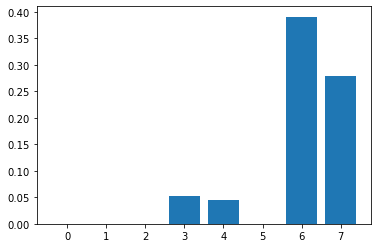

In [293]:
pyplot.bar([x for x in range(len(f_imp_used))], f_imp_used)
pyplot.show()

### In short:

**After adding the TimeJobProfile (feature 6) and TimeinPosition (feature 7) features from the chart above, we noticed that our models overestimated and to make sure we analyzed the importance of the features. We realized that in fact these two variables, when related, can contain information that can predict the target variable, independently.**

**From this moment on we decided to save the best model using these features, remove them from our future analysis and at the end make a comparison between the two scenarios.**

---

## Take 7:

**Features: Baseline(Tenure, PayIncrease, Generation) + Gender + Dependents + MProximity + MTimeJobProfile**

(TimeinPosition - TimeJobProfile, purposely withdrawn)

In [227]:
transf_v7 = ColumnTransformer(
    [('cat', OneHotEncoder(drop = 'first'), ['Generation', 'Gender', 'MProximity']),
     ('null', SimpleImputer (missing_values= np.nan, strategy = 'median'), ['PayIncrease']), 
     ('other', "passthrough", ['Tenure', 'Dependents', 'MTimeJobProfile'])
    ])

**Random Forest:**

In [228]:
model_for_7 = Pipeline([
    ('Feature Eng', transf_v7),
    ('Random Forest', RandomForestRegressor())
])

model_for_7.steps

[('Feature Eng',
  ColumnTransformer(transformers=[('cat', OneHotEncoder(drop='first'),
                                   ['Generation', 'Gender', 'MProximity']),
                                  ('null', SimpleImputer(strategy='median'),
                                   ['PayIncrease']),
                                  ('other', 'passthrough',
                                   ['Tenure', 'Dependents', 'MTimeJobProfile'])])),
 ('Random Forest', RandomForestRegressor())]

**Results:**

In [229]:
results_for_7 = cross_val_score(model_for_7, X_train, y_train, cv = KFold(n_splits = 5, shuffle = True), scoring = "roc_auc")
results_for_7_mean = results_for_7.mean()
results_for_7_std = results_for_7.std()

In [230]:
results_for_7_mean

0.7497425444008181

In [231]:
results_for_7_std

0.01430531514747315

**Gradient Boosting:**

In [232]:
model_boost_7 = Pipeline([
    ('Feature Eng', transf_v7),
    ('Gradient Boosting', GradientBoostingClassifier())
])

**Results:**

In [233]:
results_boost_7 = cross_val_score(model_boost_7, X_train, y_train, cv = KFold(n_splits = 5, shuffle = True), scoring = "roc_auc")
results_boost_7_mean = results_boost_7.mean()
results_boost_7_std = results_boost_7.std()

In [234]:
results_boost_7_mean

0.7870235612144375

In [235]:
results_boost_7_std

0.010910008951266675

---

## Take 8: 

**Features: Baseline(Tenure, PayIncrease, Generation) + Gender + Dependents + MProximity + Rehire**

(TimeinPosition - TimeJobProfile - MTimeJobProfile purposely withdrawn)

In [236]:
transf_v8 = ColumnTransformer(
    [('cat', OneHotEncoder(drop = 'first'), ['Generation', 'Gender', 'MProximity', 'Rehire']),
     ('null', SimpleImputer (missing_values= np.nan, strategy = 'median'), ['PayIncrease']), 
     ('other', "passthrough", ['Tenure', 'Dependents'])
    ])

**Random Forest:**

In [237]:
model_for_8= Pipeline([
    ('Feature Eng', transf_v8),
    ('Random Forest', RandomForestRegressor())
])

model_for_8.steps

[('Feature Eng',
  ColumnTransformer(transformers=[('cat', OneHotEncoder(drop='first'),
                                   ['Generation', 'Gender', 'MProximity',
                                    'Rehire']),
                                  ('null', SimpleImputer(strategy='median'),
                                   ['PayIncrease']),
                                  ('other', 'passthrough',
                                   ['Tenure', 'Dependents'])])),
 ('Random Forest', RandomForestRegressor())]

**Results:**

In [238]:
results_for_8 = cross_val_score(model_for_8, X_train, y_train, cv = KFold(n_splits = 5, shuffle = True), scoring = "roc_auc")
results_for_8_mean = results_for_8.mean()
results_for_8_std = results_for_8.std()

In [239]:
results_for_8_mean

0.6839410182885601

In [240]:
results_for_8_std

0.016513342636347225

**Gradient Boosting:**

In [241]:
model_boost_8 = Pipeline([
    ('Feature Eng', transf_v8),
    ('Gradient Boosting', GradientBoostingClassifier())
])

**Results:**

In [242]:
results_boost_8 = cross_val_score(model_boost_8, X_train, y_train, cv = KFold(n_splits = 5, shuffle = True), scoring = "roc_auc")
results_boost_8_mean = results_boost_8.mean()
results_boost_8_std = results_boost_8.std()

In [243]:
results_boost_8_mean

0.7322111898485764

In [244]:
results_boost_8_std

0.014602232421172746

---

## Take 9: 

**Features: Baseline(Tenure, PayIncrease, Generation) + Gender + Dependents + MProximity + Rehire + Contract Type:**

(TimeinPosition - TimeJobProfile - MTimeJobProfile purposely withdrawn)

In [245]:
transf_v9 = ColumnTransformer(
    [('cat', OneHotEncoder(drop = 'first'), ['Generation', 'Gender', 'MProximity', 'Rehire']),
     ('cat_2', OneHotEncoder(handle_unknown='ignore'), ['Contract Type']),
     ('null', SimpleImputer (missing_values= np.nan, strategy = 'median'), ['PayIncrease']), 
     ('other', "passthrough", ['Tenure', 'Dependents'])
    ])

**Random Forest:**

In [246]:
model_for_9 = Pipeline([
    ('Feature Eng', transf_v9),
    ('Random Forest', RandomForestRegressor())
])

model_for_9.steps

[('Feature Eng',
  ColumnTransformer(transformers=[('cat', OneHotEncoder(drop='first'),
                                   ['Generation', 'Gender', 'MProximity',
                                    'Rehire']),
                                  ('cat_2',
                                   OneHotEncoder(handle_unknown='ignore'),
                                   ['Contract Type']),
                                  ('null', SimpleImputer(strategy='median'),
                                   ['PayIncrease']),
                                  ('other', 'passthrough',
                                   ['Tenure', 'Dependents'])])),
 ('Random Forest', RandomForestRegressor())]

**Results:**

In [247]:
results_for_9 = cross_val_score(model_for_9, X_train, y_train, cv = KFold(n_splits = 5, shuffle = True), scoring = "roc_auc")
results_for_9_mean = results_for_9.mean()
results_for_9_std = results_for_9.std()

In [248]:
results_for_9_mean

0.7745101861330362

In [249]:
results_for_9_std

0.014609338624087791

**Gradient Boosting:**

In [250]:
model_boost_9 = Pipeline([
    ('Feature Eng', transf_v9),
    ('Gradient Boosting', GradientBoostingClassifier())
])

**Results:**

In [251]:
results_boost_9 = cross_val_score(model_boost_9, X_train, y_train, cv = KFold(n_splits = 5, shuffle = True), scoring = "roc_auc")
results_boost_9_mean = results_boost_9.mean()
results_boost_9_std = results_boost_9.std()

In [252]:
results_boost_9_mean

0.7912322040364642

In [253]:
results_boost_9_std

0.01656981598667773

---

## Take 10:

**Features: Baseline(Tenure, PayIncrease, Generation) + Gender + Dependents + MProximity + Rehire + Contract Type + PeopleManager:**

(TimeinPosition - TimeJobProfile - MTimeJobProfile purposely withdrawn)

In [254]:
transf_v10 = ColumnTransformer(
    [('cat', OrdinalEncoder(), ['Generation', 'Gender', 'MProximity', 'Rehire', 'Contract Type', 'PeopleManager']),
     ('null', SimpleImputer (missing_values= np.nan, strategy = 'median'), ['PayIncrease']), 
     ('other', "passthrough", ['Tenure', 'Dependents'])
    ])

**Random Forest:**

In [255]:
model_for_10 = Pipeline([
    ('Feature Eng', transf_v10),
    ('Random Forest', RandomForestRegressor())
])

model_for_10.steps

[('Feature Eng',
  ColumnTransformer(transformers=[('cat', OrdinalEncoder(),
                                   ['Generation', 'Gender', 'MProximity',
                                    'Rehire', 'Contract Type', 'PeopleManager']),
                                  ('null', SimpleImputer(strategy='median'),
                                   ['PayIncrease']),
                                  ('other', 'passthrough',
                                   ['Tenure', 'Dependents'])])),
 ('Random Forest', RandomForestRegressor())]

**Results:**

In [256]:
results_for_10 = cross_val_score(model_for_10, X_train, y_train, cv = KFold(n_splits = 5, shuffle = True), scoring = "roc_auc")
results_for_10_mean = results_for_10.mean()
results_for_10_std = results_for_10.std()

In [257]:
results_for_10_mean

0.7879767199297444

**Gradient Boosting:**

In [258]:
model_boost_10 = Pipeline([
    ('Feature Eng', transf_v10),
    ('Gradient Boosting', GradientBoostingClassifier())
])

**Results:**

In [259]:
results_boost_10 = cross_val_score(model_boost_10, X_train, y_train, cv = KFold(n_splits = 5, shuffle = True), scoring = "roc_auc")
results_boost_10_mean = results_boost_10.mean()
results_boost_10_std = results_boost_10.std()

In [260]:
results_boost_10_mean

0.7951554587549035

---

## Take 11: 

**Features: Baseline(Tenure, PayIncrease, Generation) + Gender + Dependents + MProximity + Rehire + Contract Type + PeopleManager + Country:**

(TimeinPosition - TimeJobProfile - MTimeJobProfile purposely withdrawn)

In [261]:
transf_v11 = ColumnTransformer(
    [('cat', OrdinalEncoder(), ['Generation', 'Gender', 'MProximity', 'Rehire', 'Contract Type', 'PeopleManager', 'Country']),
     ('null', SimpleImputer (missing_values= np.nan, strategy = 'median'), ['PayIncrease']), 
     ('other', "passthrough", ['Tenure', 'Dependents'])
    ])

**Random Forest:**

In [262]:
model_for_11 = Pipeline([
    ('Feature Eng', transf_v11),
    ('Random Forest', RandomForestRegressor())
])

model_for_11.steps

[('Feature Eng',
  ColumnTransformer(transformers=[('cat', OrdinalEncoder(),
                                   ['Generation', 'Gender', 'MProximity',
                                    'Rehire', 'Contract Type', 'PeopleManager',
                                    'Country']),
                                  ('null', SimpleImputer(strategy='median'),
                                   ['PayIncrease']),
                                  ('other', 'passthrough',
                                   ['Tenure', 'Dependents'])])),
 ('Random Forest', RandomForestRegressor())]

**Results:**

In [263]:
results_for_11 = cross_val_score(model_for_11, X_train, y_train, cv = KFold(n_splits = 5, shuffle = True), scoring = "roc_auc")
results_for_11_mean = results_for_11.mean()
results_for_11_std = results_for_11.std()

In [264]:
results_for_11_mean

0.7918403317130434

**Gradient Boosting:**

In [265]:
model_boost_11 = Pipeline([
    ('Feature Eng', transf_v11),
    ('Gradient Boosting', GradientBoostingClassifier())
])

**Results:**

In [266]:
results_boost_11 = cross_val_score(model_boost_11, X_train, y_train, cv = KFold(n_splits = 5, shuffle = True), scoring = "roc_auc")
results_boost_11_mean = results_boost_11.mean()
results_boost_11_std = results_boost_11.std()

In [267]:
results_boost_11_mean

0.8046136295585187

---

## Take 12: BOOST!

In this take, in contrast to the previous takes in which we only added one variable at a time, we decided to start from what we already had and try all combinations of variables until we reached the best possible model.

Note: As with the TimeinPosition and TimeJobProfile variables, the MTimeJobProfile and TerminationCount variables also showed suspicious evolution of the model when added, and for this reason they were purposely removed.

**Features: Baseline(Tenure, PayIncrease, Generation) + Gender + Dependents + MProximity + Rehire + Contract Type + PeopleManager + Country + [CostCenterH, TopPerformer, PayIncrease, Age, EmployeeCount, HireCount, MTenure, HomeOffice]:**

(TimeinPosition - TimeJobProfile - MTimeJobProfile (+8% Random Forest e 7% Gradient Boosting) - Termination Count (+9% Random Forest e 7% Gradient Boosting) purposely withdrawn)

In [268]:
transf_v12 = ColumnTransformer(
    [('cat', OrdinalEncoder(), ['Generation', 'Gender', 'MProximity', 'Rehire', 'Contract Type', 'PeopleManager', 'Country', 'CostCenterH', 'TopPerformer']),
     ('null', SimpleImputer (missing_values= np.nan, strategy = 'median'), ['PayIncrease', 'Age']), 
     ('other', "passthrough", ['Tenure', 'Dependents', 'EmployeeCount', 'HireCount', 'MTenure', 'HomeOffice'])
    ])

**Random Forest:**

In [269]:
model_for_12 = Pipeline([
    ('Feature Eng', transf_v12),
    ('Random Forest', RandomForestRegressor())
])

model_for_12.steps

[('Feature Eng',
  ColumnTransformer(transformers=[('cat', OrdinalEncoder(),
                                   ['Generation', 'Gender', 'MProximity',
                                    'Rehire', 'Contract Type', 'PeopleManager',
                                    'Country', 'CostCenterH', 'TopPerformer']),
                                  ('null', SimpleImputer(strategy='median'),
                                   ['PayIncrease', 'Age']),
                                  ('other', 'passthrough',
                                   ['Tenure', 'Dependents', 'EmployeeCount',
                                    'HireCount', 'MTenure', 'HomeOffice'])])),
 ('Random Forest', RandomForestRegressor())]

**Results:**

In [270]:
results_for_12 = cross_val_score(model_for_12, X_train, y_train, cv = KFold(n_splits = 5, shuffle = True), scoring = "roc_auc")
results_for_12_mean = results_for_12.mean()
results_for_12_std = results_for_12.std()

In [271]:
results_for_12_mean

0.8881864761059853

In [272]:
results_for_12_std

0.010893979699297123

**Gradient Boosting:**

In [273]:
model_boost_12 = Pipeline([
    ('Feature Eng', transf_v12),
    ('Gradient Boosting', GradientBoostingClassifier())
])

**Results:**

In [274]:
results_boost_12 = cross_val_score(model_boost_12, X_train, y_train, cv = KFold(n_splits = 5, shuffle = True), scoring = "roc_auc")
results_boost_12_mean = results_boost_12.mean()
results_boost_12_std = results_boost_12.std()

In [275]:
results_boost_12_mean

0.8724273218311556

In [276]:
results_boost_12_std

0.01226452218460787

----

## Take 13: 

**Evaluation of the Model with overestimating features:**

**Take 12** + TimeinPosition + TimeJobProfile + MTimeJobProfile + Termination Count

In [277]:
transf_v13 = ColumnTransformer(
    [('cat', OrdinalEncoder(), ['Generation', 'Gender', 'MProximity', 'Rehire', 'Contract Type', 'PeopleManager', 'Country', 'CostCenterH', 'TopPerformer']),
     ('null', SimpleImputer (missing_values= np.nan, strategy = 'median'), ['PayIncrease', 'Age']), 
     ('other', "passthrough", ['Tenure', 'Dependents', 'EmployeeCount', 'HireCount', 'MTenure', 'HomeOffice','TimeinPosition', 'TimeJobProfile', 'MTimeJobProfile', 'TerminationCount'])
    ])

**Random Forest:**

In [278]:
model_for_13 = Pipeline([
    ('Feature Eng', transf_v13),
    ('Random Forest', RandomForestRegressor())
])

model_for_13.steps

[('Feature Eng',
  ColumnTransformer(transformers=[('cat', OrdinalEncoder(),
                                   ['Generation', 'Gender', 'MProximity',
                                    'Rehire', 'Contract Type', 'PeopleManager',
                                    'Country', 'CostCenterH', 'TopPerformer']),
                                  ('null', SimpleImputer(strategy='median'),
                                   ['PayIncrease', 'Age']),
                                  ('other', 'passthrough',
                                   ['Tenure', 'Dependents', 'EmployeeCount',
                                    'HireCount', 'MTenure', 'HomeOffice',
                                    'TimeinPosition', 'TimeJobProfile',
                                    'MTimeJobProfile', 'TerminationCount'])])),
 ('Random Forest', RandomForestRegressor())]

**Results:**

In [279]:
results_for_13 = cross_val_score(model_for_13, X_train, y_train, cv = KFold(n_splits = 5, shuffle = True), scoring = "roc_auc")
results_for_13_mean = results_for_13.mean()
results_for_13_std = results_for_13.std()

In [280]:
results_for_13_mean

0.9705899030278733

In [281]:
results_for_13_std

0.007221082196516358

**Gradient Boosting:**

In [282]:
model_boost_13 = Pipeline([
    ('Feature Eng', transf_v13),
    ('Gradient Boosting', GradientBoostingClassifier())
])

**Results:**

In [283]:
results_boost_13 = cross_val_score(model_boost_13, X_train, y_train, cv = KFold(n_splits = 5, shuffle = True), scoring = "roc_auc")
results_boost_13_mean = results_boost_13.mean()
results_boost_13_std = results_boost_13.std()

In [284]:
results_boost_13_mean

0.9650644646334706

In [285]:
results_boost_13_std

0.006273823096615139

---

**Best overall models were divide between the best ones with and without overestimating variables. We will now build a Grid with the specific parameters for our models to adopt, on the next notebook "Predict Talent Migration with Machine Learning - 03 Grid Build"**